In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
import DiscreteCondEnt as DC

from sklearn.metrics import mean_squared_error
def MSEscorer(clf, X, y):
    y_est = clf.predict(X)
    return np.log(mean_squared_error(y, y_est)*3.14159*2)/2

def varEntropy(y):
    return np.log(np.var(y)*3.14159*2)/2

from sklearn.linear_model import LinearRegression
linReg = LinearRegression()

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor()

x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,1],[1,1]],
                                 size = 300)
x = np.transpose(x)

CVFold = 3
DEntropy = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)

In [23]:
x2 = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)
x2 = np.transpose(x2)

In [24]:
DEntropy2 = DC.computeEnt(x2, linReg, MSEscorer, varEntropy, CVFold)

In [25]:
DEntropy

array([[9.20094469e-01, 2.92948188e-32],
       [9.20094469e-01, 2.63948274e-32]])

In [26]:
#MI
MI12_1 = DEntropy[0,0] - DEntropy[0,1]
MI12_2 = DEntropy[1,0] - DEntropy[1,1]
print (MI12_1, MI12_2)

0.9200944688639072 0.9200944688639068


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [71]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [78]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [73]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

In [84]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+2), log_freq=int(1e+3), verbose=True):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if verbose and (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [75]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [86]:
x3 = np.random.multivariate_normal( mean=[0,0], cov=[[1,0],[0,1]], size = 300)
mine_net_indep = Mine()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = train(x3,mine_net_indep,mine_net_optim_indep, verbose=False)

-1.0088212e-05


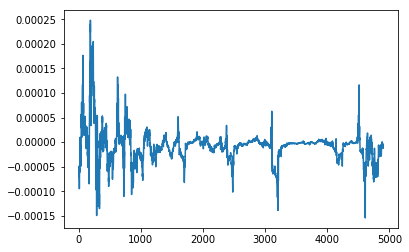

In [83]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [88]:
MINE = []
LinReg = []
GT = []
COV = np.linspace(-0.9, 0.9, 19)
for cov in COV:
    x = np.transpose(np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,cov],[cov,1]],
                                 size = 100))
    DE = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
    MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
    MI = MI/2
    LinReg.append(MI)
    #plt.scatter(cov, MI, c='g',label='KNN-regressor')
    groundTruth = -0.5*np.log(1-cov*cov)
    GT.append(groundTruth)
    #plt.scatter(cov, groundTruth, c='r',label='ground truth')
    
    #MINE
    mine_net = Mine()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(np.transpose(x),mine_net,mine_net_optim)
    result_ma = ma(result)
    MINE.append(result_ma[-1])
    #MINE

#plt.legend()
#plt.show()

0.7139768
0.6316654
0.7826391
0.7373528
0.71534747
0.33773124
0.49103215
0.40218806
0.4783399
0.44352362
0.2582965
0.40100932
0.21344906
0.3392538
0.3488893
0.27446285
0.1057293
0.14917296
0.2677378
0.18660794
0.097245224
0.14853635
0.21353453
0.051186815
0.10429295
0.11462825
-0.004557647
0.055703018
0.15233307
0.05741871
0.003936209
-0.051913593
0.026658354
0.045222223
0.030030468
4.7496324e-05
0.0023006122
0.02391725
0.03362205
0.036872778
0.006231467
0.0013570078
0.006279491
-0.0018430948
0.019196901
-1.20903715e-05
4.4165023e-05
4.2699103e-06
-3.7585269e-06
-0.00031646813
-0.0008236333
8.823799e-06
2.8283917e-05
-9.653637e-05
2.5724818e-05
-6.722513e-05
0.0014087242
0.01146451
0.013907462
0.007841862
0.0912253
0.122383095
0.056839854
0.10575047
0.0782597
0.03139615
0.22487295
0.032391477
0.058252454
0.16545579
0.1887874
0.10880328
0.21021816
0.23530854
0.08429229
0.3004536
0.21730933
0.15396884
0.20488712
0.23025325
0.60854334
0.40914047
0.3779331
0.31298184
0.47951263
0.26784778


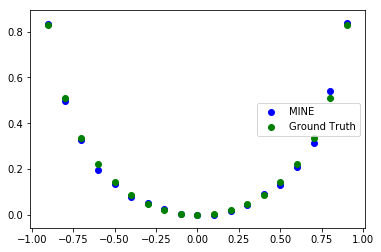

In [92]:
fig, ax = plt.subplots()

ax.scatter(COV, MINE, c='b', label='MINE')
#ax.scatter(COV, LinReg, c='r', label='Regressor')
ax.scatter(COV, GT, c='g', label='Ground Truth')

ax.legend()
plt.show()

In [91]:
MINE2 = []
LinReg2 = []
GT2 = []
COV2 = []
for i in range(1, 8):
    cov = 1 - 0.1**i
    COV2.append(cov)
    x = np.transpose(np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,cov],[cov,1]],
                                 size = 10000))
    DE = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
    MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
    MI = MI/2
    LinReg2.append(MI)
    #plt.scatter(cov, MI, c='g',label='KNN-regressor')
    groundTruth = -0.5*np.log(1-cov*cov)
    GT2.append(groundTruth)
    #plt.scatter(cov, groundTruth, c='r',label='ground truth')
    
#     #MINE
#     mine_net = Mine()
#     mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
#     result = train(np.transpose(x),mine_net,mine_net_optim)
#     result_ma = ma(result)
#     MINE2.append(result_ma[-1])
#     #MINE

#plt.legend()
#plt.show()

0.6838852
0.91718066
0.8484288
0.78330123
0.46787655
2.4472227
2.145537
2.5620003
1.7462051
1.6097094
3.2292209
3.189553
2.6548195
3.2587643
3.751107
3.4347908
3.327949
3.7095993
4.3756294
4.9397445
3.6102746
4.189102
4.8895807
3.5474145
4.2899437
4.25937
3.4531517
4.8590817
4.1522355
3.581197
3.686964
4.629438
8.012478
4.9360285
14.732037


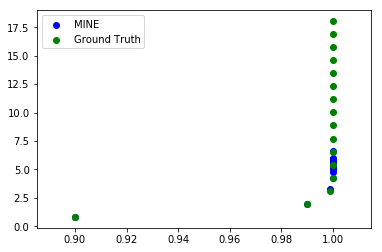

In [108]:
fig, ax = plt.subplots()

ax.scatter(COV2, MINE2, c='b', label='MINE')
#ax.scatter(COV2, LinReg2, c='r', label='Regressor')
ax.scatter(COV2, GT2, c='g', label='Ground Truth')

ax.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


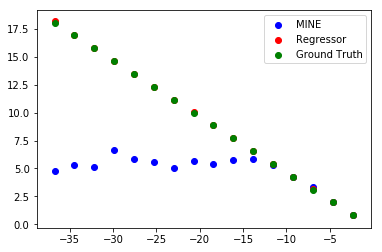

In [106]:
fig, ax = plt.subplots()
COV22 = np.log(np.ones(len(COV2)) - COV2)
ax.scatter(COV22, MINE2, c='b', label='MINE')
ax.scatter(COV22, LinReg2, c='r', label='Regressor')
ax.scatter(COV22, GT2, c='g', label='Ground Truth')

ax.legend()
plt.show()

In [107]:
np.log(10000)

9.210340371976184

In [104]:
for i in range(8, 20):
    cov = 1 - 0.1**i
    COV2.append(cov)
    x = np.transpose(np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,cov],[cov,1]],
                                 size = 10000))
    DE = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
    MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
    MI = MI/2
    LinReg2.append(MI)
    #plt.scatter(cov, MI, c='g',label='KNN-regressor')
    groundTruth = -0.5*np.log(1-cov*cov)
    GT2.append(groundTruth)
    #plt.scatter(cov, groundTruth, c='r',label='ground truth')
    
    #MINE
    mine_net = Mine()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(np.transpose(x),mine_net,mine_net_optim)
    result_ma = ma(result)
    MINE2.append(result_ma[-1])
    #MINE


4.1018114
5.719031
4.925558
5.036795
4.860683
3.939142
4.0863094
3.7627614
4.9275703
7.447962
3.5613244
6.847351
6.5556297
6.4137144
5.5157366
4.077453
6.1694155
4.7401958
4.2466965
8.159683
3.1441705
12.408489
5.5862813
5.1209526
5.0138783
4.0317445
3.7254608
2.1680317
5.194463
5.2940736
4.9103403
2.9698486
3.469598
6.269966
5.130463
3.7743385
5.3607063
4.9128137
4.5146365
4.81076
4.0846624
4.2393556
5.7824535
5.574537
3.5774617


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


3.295353
4.1492805
5.19768
4.386994
4.258513


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


4.225566
3.5524883
4.3728476
6.1828737
4.6994576


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


3.9178414
3.9703667
6.260885
4.112125
4.8858256
